# XAI Experiment Data Analysis - Playground

This notebook contains random experiments on the data without the goal of answering the research questions.

In [2]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import pingouin as pg

## Import data

### Read questionnaire data

In [3]:
df_v1 = pd.read_csv('data/v1_cleaned.csv')
df_v2 = pd.read_csv('data/v2_cleaned.csv')
df_v3 = pd.read_csv('data/v3_cleaned.csv')

In [4]:
# merge the two dataframes
df = pd.concat([df_v1, df_v2, df_v3], ignore_index=True)

In [5]:
# make sure seperate dataframes are not used
del df_v1
del df_v2
del df_v3

### Read news items

In [6]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [7]:
newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [8]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                       "title", "subtitle", "content",
                       "source", "publishing_date", "category",
                       "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                       "is_false_positive", "is_true_negative", "is_qualification"]]

In [9]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN), 
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [10]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [11]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [12]:
newsitems

,id,title,subtitle,content,source,publishing_date,category,highlighted_content,truthfulness,readability,natural_language_explanation,is_false_positive,is_true_negative,is_qualification,is_fake_news
7,7,"Facing unbearable heat, Qatar has begun to air...",2°C: BEYOND THE LIMIT,"Already one of the hottest places on Earth, Qa...",Trustworthy Source,10/16/2019,Environment,"Already one of the hottest places on Earth, Qa...",90,medium,Qatar is one of the hottest countries on earth...,False,False,False,False
8,8,Survival International launches campaign to st...,NaN,Survival International today (Earth Day) launc...,Untrustworthy Source,04/22/2022,Environment,Survival International today (Earth Day) launc...,47,medium,The statement by Survival International that 3...,False,False,False,True
9,9,How Biden's climate plan could limit you to ea...,NaN,President Joe Biden's ambitious plan to slash ...,Untrustworthy Source,04/22/2021,Environment,President Joe Biden's ambitious plan to <span ...,5,easy,President Joe Biden’s climate plans do not inc...,False,False,False,True
10,10,Several Israelis wounded in attack on Jerusale...,Israeli police arrest suspected gunman after a...,Israeli police arrested a suspect in a shootin...,Trustworthy Source,8/14/2022,Crime,"""<mark>Israeli police arrested a suspect in a ...",92,medium,Israeli forces have allegedly been raiding hou...,False,False,True,False
11,11,Young Girl Hitchhiked Through The Middle East ...,NaN,Here’s a shocking and sad story that should be...,Untrustworthy Source,4/14/2016,Crime,"""<span style='background-color:#00FEFE'>Here’s...",21,easy,The article misleads the readers about the tim...,False,False,False,True
12,12,Military Arrests Bill Gates,NaN,The U.S. military on Tuesday arrested Microsof...,Untrustworthy Source,8/1/2021,Crime,"""The U.S. military on Tuesday arrested Microso...",3,easy,Real Raw News is a website that contains humor...,False,False,True,True
13,13,JOE BIDEN SAYS BIBLE BELIEVING CHRISTIANS VIOL...,"In too many places, Joe Biden said today, LGBT...",Vice President Joe Biden say today that the ri...,Untrustworthy Source,05/17/2015,Gender,<mark>Vice President Joe Biden say today that ...,97,easy,The NTEB headline misrepresented Biden's state...,True,False,False,True
14,14,Boys need to talk more about feelings and figh...,The Global Boyhood Initiative aims to enable a...,Boys should be encouraged to ignore gender ste...,Trustworthy Source,11/8/2022,Gender,Boys should be <span style='background-color:#...,10,hard,"""The State of UK Boys"" report has been release...",False,True,False,False


## Filtering out assumed cheaters

Assume that participants who did answer at least 5 out of 6 control questions correctly were paying attention and gave valid answers.

In [13]:
# participants who did not get 2 points in the qualification shouldn't be considered
df = df[df['POINTS.qualification'] == 2]

In [14]:
df = df[df["POINTS.main"] >= 5]

In [15]:
df["METADATA.FEATURE"].value_counts()

salient         140
basic           133
explanations    133
Name: METADATA.FEATURE, dtype: int64

## Define Kruskal-Wallis test function

In [16]:
def perform_kruskal_with_posthoc(df, col, print_results=True, between="METADATA.FEATURE"):
    if print_results:
        print("Column name:", col)

    kruskal_test = pg.kruskal(df, dv=col, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    if print_results:
        print("kruskal_pval", kruskal_pval, "\n")


    posthoc = pg.pairwise_tests(df, dv=col, between=between, parametric=False, padjust="holm")

    # print stuff if p-corr is smaller than 0.05 in all the comparisons
    if print_results:
        print(posthoc[["A", "B", "p-unc", "p-corr"]], "\n")

    if print_results:
        print(df.groupby(between)[col].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[col].describe()

## Are features too complicated?

In [17]:
perform_kruskal_with_posthoc(df, "news-dashboard-evaluation.complicated-explainability-features");

Column name: news-dashboard-evaluation.complicated-explainability-features
kruskal_pval 0.00894585663639253 

              A             B     p-unc    p-corr
0         basic  explanations  0.027623  0.055245
1         basic       salient  0.002799  0.008398
2  explanations       salient  0.563233  0.563233 

                      mean       std
METADATA.FEATURE                    
basic             3.142857  1.647509
explanations      2.819549  1.808375
salient           2.621429  1.561533 



## Assumptions of normality

What to do instead of a t-test or ANOVA if the data is not normally distributed?

https://stats.stackexchange.com/a/5946

Instead of a t-test, we can use a Mann-Whitney U test (works for unbalanced groups).

Instead of an ANOVA, we can use a Kruskal-Wallis H test (works for unbalanced groups).


In [18]:
expectation_cols = [col for col in df.columns if col.startswith('expectations.')]
ai_system_eval_cols = [col for col in df.columns if col.startswith('ai-system-evaluation.')]
newsdashboard_eval_cols = [col for col in df.columns if col.startswith('news-dashboard-evaluation.')]

In [19]:
normality_data = []

for col in ai_system_eval_cols + newsdashboard_eval_cols \
    + ["METADATA.workDurationInSeconds.main", "METADATA.workDurationInSeconds.qualification"]:
    # if not a numeric column, skip
    if df[col].dtype != "float64" and df[col].dtype != "int64":
        continue

    df_wide = pd.DataFrame(
                {'basic': df.loc[df['METADATA.FEATURE'] == 'basic'][col],
                 'salient': df.loc[df['METADATA.FEATURE'] == 'salient'][col],
                 'explanations': df.loc[df['METADATA.FEATURE'] == 'explanations'][col]}) 

    # check normality
    normality_test_basic = pg.normality(df_wide['basic'])
    normality_test_salient = pg.normality(df_wide['salient'])
    normality_test_explanations = pg.normality(df_wide['explanations'])

    basic_is_normal = normality_test_basic["normal"].values[0]
    basic_pval = normality_test_basic["pval"].values[0]

    salient_is_normal = normality_test_salient["normal"].values[0]
    salient_pval = normality_test_salient["pval"].values[0]

    explanations_is_normal = normality_test_explanations["normal"].values[0]
    explanations_pval = normality_test_explanations["pval"].values[0]

    basic_mean, salient_mean, explanations_mean = df_wide.describe().loc[["mean"]].values[0]
    basic_std, salient_std, explanations_std = df_wide.describe().loc[["std"]].values[0]

    if basic_is_normal or salient_is_normal or explanations_is_normal:
        print(f"{col} is normal distributed")
    normality_data.append([col.split(".")[1], basic_mean, basic_std, basic_is_normal, basic_pval, salient_mean, salient_std, salient_is_normal, salient_pval, explanations_mean, explanations_std, explanations_is_normal, explanations_pval])

normality_df = pd.DataFrame(normality_data, columns=["col", "basic_mean", "basic_std", "basic_is_normal", "basic_pval", "salient_mean", "salient_std", "salient_is_normal", "salient_pval", "explanations_mean", "explanations_std", "explanations_is_normal", "explanations_pval"]);

ai-system-evaluation.everyday-work-helpful is normal distributed
ai-system-evaluation.system-has-functionality-for-work is normal distributed


## Comparision of 3 groups

In [21]:
# do a kruskal wallis test for all the columns

from pingouin import kruskal, anova

test_data = []

for col in ai_system_eval_cols + newsdashboard_eval_cols:
    # if not a numeric column, skip
    if df[col].dtype != "float64" and df[col].dtype != "int64":
        continue

    kruskal, posthoc, describe = perform_kruskal_with_posthoc(df, col, False)

    basic_salient = posthoc.loc[(posthoc["A"] == "basic") & (posthoc["B"] == "salient")]
    basic_explanations = posthoc.loc[(posthoc["A"] == "basic") & (posthoc["B"] == "explanations")]
    explanations_salient = posthoc.loc[(posthoc["A"] == "explanations") & (posthoc["B"] == "salient")]

    test_data.append(
        [
            col.split(".")[0],
            col.split(".")[1],
            kruskal["p-unc"].values[0],
            basic_salient["p-corr"].values[0],
            basic_explanations["p-corr"].values[0],
            explanations_salient["p-corr"].values[0],
            describe["mean"]["basic"],
            describe["mean"]["salient"],
            describe["mean"]["explanations"],
        ]
    )

test_df = pd.DataFrame(test_data, columns=["cat", "feature", "kruskal_pval", "basic_salient_pval_corr", "basic_explanations_pval_corr", "salient_explanations_pval_corr", "basic_mean", "salient_mean", "explanations_mean"])

test_df.sort_values(by="kruskal_pval")

,cat,feature,kruskal_pval,basic_salient_pval_corr,basic_explanations_pval_corr,salient_explanations_pval_corr,basic_mean,salient_mean,explanations_mean
20,ai-system-evaluation,understand-what-system-bases-decision-on,0.000004,0.000002,0.016794,0.017181,4.992481,5.742857,5.383459
1,ai-system-evaluation,classification-comprehensible,0.000014,0.000016,0.002329,0.157755,5.157895,5.771429,5.639098
4,ai-system-evaluation,know-what-will-happen-next-time,0.000035,0.000036,0.002917,0.243408,4.669173,5.457143,5.233083
31,news-dashboard-evaluation,useful-explanations-news,0.000100,0.010362,0.000085,0.123069,5.127820,5.535714,5.796992
21,ai-system-evaluation,understand-why-system-provided-decision,0.000156,0.000160,0.006780,0.256984,5.052632,5.650000,5.518797
12,ai-system-evaluation,system-decides-consistently,0.000288,0.000176,0.045045,0.083154,4.300752,5.050000,4.744361
16,ai-system-evaluation,system-supports-decision-making,0.000290,0.488541,0.000274,0.005803,5.067669,5.064286,5.593985
24,news-dashboard-evaluation,comprehensible-explanations-help-assess-news-a...,0.000569,0.311646,0.000514,0.012613,5.248120,5.371429,5.827068
5,ai-system-evaluation,rely-on-ai-system,0.000650,0.935905,0.002310,0.002310,4.563910,4.507143,5.060150
2,ai-system-evaluation,easy-to-follow-what-system-does,0.001463,0.001326,0.092402,0.092402,5.082707,5.685714,5.398496


## Group AI system evaluation features

I am not sure how to group ai-system-evaluation questions.

In [22]:
competence_columns = ['ai-system-evaluation.system-supports-decision-making',
                'ai-system-evaluation.system-able-to-classify-news-articles',
                'ai-system-evaluation.system-can-correctly-classify-news-articles',
                'ai-system-evaluation.system-can-efficiently-classify-news-articles',
                'ai-system-evaluation.system-able-to-detect-fake-news']

integrity_columns = ['ai-system-evaluation.system-decides-neutral',
                'ai-system-evaluation.system-decides-consistently',
                'ai-system-evaluation.system-criteria-acceptable']

transparency_columns = ['ai-system-evaluation.understand-why-system-provided-decision',
                'ai-system-evaluation.understand-what-system-bases-decision-on',
                'ai-system-evaluation.classification-comprehensible',
                'ai-system-evaluation.easy-to-follow-what-system-does',
                'news-dashboard-evaluation.satisfied-with-explanatory-quality',
                'ai-system-evaluation.know-what-will-happen-next-time']

trust_overall_columns = ['ai-system-evaluation.tend-to-trust-system-even-without-knowledge',
                         'ai-system-evaluation.tendency-to-trust-system-high']

column_groups = [
  ("competence", competence_columns),
  ("integrity", integrity_columns),
  ("transparency", transparency_columns),
  ("trust_overall", trust_overall_columns)
]

In [23]:
from pingouin import cronbach_alpha

for name, columns in column_groups:
    print(name)
    if not len(columns) == 1:
        print("cronbach_alpha", cronbach_alpha(df[columns]))

    df[name] = df[columns].sum(axis=1)

    perform_kruskal_with_posthoc(df, name, True)

competence
cronbach_alpha (0.9340178966958701, array([0.923, 0.944]))
Column name: competence
kruskal_pval 0.006246970583259041 

              A             B     p-unc    p-corr
0         basic  explanations  0.001457  0.004371
1         basic       salient  0.322913  0.322913
2  explanations       salient  0.039601  0.079203 

                       mean       std
METADATA.FEATURE                     
basic             25.466165  5.716204
explanations      27.533835  5.836859
salient           25.714286  6.850181 

integrity
cronbach_alpha (0.7269880802071341, array([0.678, 0.77 ]))
Column name: integrity
kruskal_pval 0.043483060896111 

              A             B     p-unc    p-corr
0         basic  explanations  0.025033  0.075098
1         basic       salient  0.038264  0.076527
2  explanations       salient  0.719116  0.719116 

                       mean       std
METADATA.FEATURE                     
basic             13.015038  4.037673
explanations      14.127820  3.9049

## Most useful explanation feature

In [24]:
df.groupby("METADATA.FEATURE")["ai-system-evaluation.most-useful-explanation-feature"].value_counts(normalize=True) * 100

METADATA.FEATURE  ai-system-evaluation.most-useful-explanation-feature
basic             information-about-the-source                            55.639098
                  truthfulness-assessment                                 34.586466
                  publishing-date                                          9.774436
explanations      natural-language-explanation                            52.631579
                  information-about-the-source                            26.315789
                  truthfulness-assessment                                 21.052632
salient           information-about-the-source                            34.285714
                  text-highlights                                         31.428571
                  sentiment-highlights                                    15.714286
                  truthfulness-assessment                                 15.714286
                  readability                                              2.857143
Name:

Most useful explanation feature according to the participants was information about the source in baseline and salient explanations by a high margin, however, natual language explanations were rated the most useful in the AI system explanation group. Not possible to compare using statistical tests because there were different choices in the different groups.

## Speed vs comprehensiveness

In [25]:
df["ai-system-evaluation.value-speed-or-comprehensiveness"].value_counts(normalize=True) * 100

comprehensiveness    90.640394
speed                 9.359606
Name: ai-system-evaluation.value-speed-or-comprehensiveness, dtype: float64

In [26]:
df.groupby("METADATA.FEATURE")["ai-system-evaluation.value-speed-or-comprehensiveness"].value_counts(normalize=True) * 100

METADATA.FEATURE  ai-system-evaluation.value-speed-or-comprehensiveness
basic             comprehensiveness                                        93.984962
                  speed                                                     6.015038
explanations      comprehensiveness                                        88.721805
                  speed                                                    11.278195
salient           comprehensiveness                                        89.285714
                  speed                                                    10.714286
Name: ai-system-evaluation.value-speed-or-comprehensiveness, dtype: float64

In [27]:
from pingouin import chi2_independence

expected, observed, stats = chi2_independence(df, x='METADATA.FEATURE', y='ai-system-evaluation.value-speed-or-comprehensiveness')

In [28]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,2.633615,2.0,0.267989,0.080540,0.286361
1,cressie-read,0.666667,2.689946,2.0,0.260547,0.081397,0.291778
2,log-likelihood,0.000000,2.820077,2.0,0.244134,0.083343,0.304280
3,freeman-tukey,-0.500000,2.934860,2.0,0.230517,0.085022,0.315288
4,mod-log-likelihood,-1.000000,3.066479,2.0,0.215835,0.086907,0.327879
5,neyman,-2.000000,3.389528,2.0,0.183643,0.091371,0.358580


Interpretation: High p-values indicate that there's no significant difference in what users value more: speed or comprehensiveness among the different groups. Overall, 91.1051% of the participants valued comprehensiveness more than speed.

## Removing people who were too fast?

Being too fast might indicate that the participant might did not pay attention. The qualification we estimated to take 10 mins and the main part 20 mins.

In [29]:
# print distribution of the duration values
df['METADATA.workDurationInMinutes.qualification'] = df['METADATA.workDurationInSeconds.qualification'] / 60
df['METADATA.workDurationInMinutes.main'] = df['METADATA.workDurationInSeconds.main'] / 60

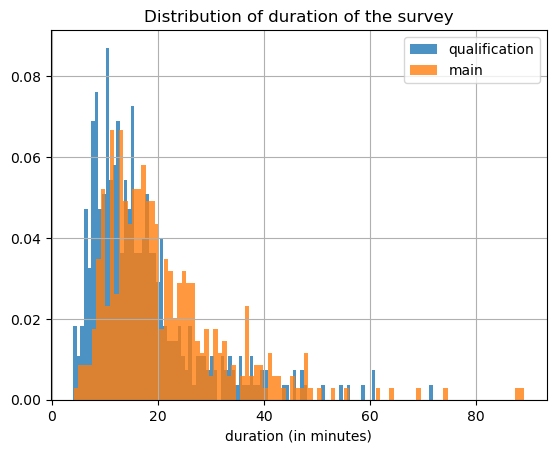

In [30]:
df['METADATA.workDurationInMinutes.qualification'].hist(bins=100, density=True, alpha=0.8);
df['METADATA.workDurationInMinutes.main'].hist(bins=100, density=True, alpha=0.8);
plt.title("Distribution of duration of the survey")
plt.xlabel("duration (in minutes)")
plt.legend(["qualification", "main"]);

We don't see spikes in the lower end of the time distribution, so we don't remove any participants.

## Are AI-preference and the trust measures correlated?

In [32]:
# code won't work since ai-preference is not in this notebook

# local_eval_data = df[["ai-preference", "competence", "integrity", "transparency", "trust_overall"]]

# corr_df = pg.pairwise_corr(local_eval_data, method="spearman", padjust="holm")
# corr_df = corr_df[corr_df["X"] == "ai-preference"]
# corr_df

## Difference in speed between groups?

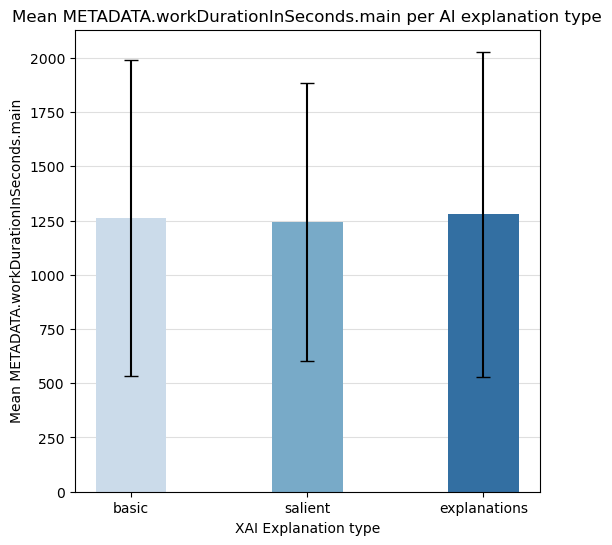

In [33]:
speed_col = "METADATA.workDurationInSeconds.main"
ai_pref_data = df.groupby("METADATA.FEATURE")[speed_col].describe()[["mean", "std"]].reset_index()
ai_pref_data["METADATA.FEATURE"] = pd.Categorical(ai_pref_data["METADATA.FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
ai_pref_data = ai_pref_data.sort_values("METADATA.FEATURE")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="METADATA.FEATURE", y="mean", data=ai_pref_data, ax=ax, palette="Blues", width=.4)
ax.set_ylabel(f"Mean {speed_col}")
ax.set_xlabel("XAI Explanation type")
ax.set_title(f"Mean {speed_col} per AI explanation type")
ax.errorbar(x=ai_pref_data["METADATA.FEATURE"], y=ai_pref_data["mean"], yerr=ai_pref_data["std"], fmt='none', c='black', capsize=5)
# have a grid on the y-axis
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

In [34]:
perform_kruskal_with_posthoc(df, "METADATA.workDurationInSeconds.qualification", True);
perform_kruskal_with_posthoc(df, "METADATA.workDurationInSeconds.main", True);

Column name: METADATA.workDurationInSeconds.qualification
kruskal_pval 0.1899642961132677 

              A             B     p-unc    p-corr
0         basic  explanations  0.715689  0.715689
1         basic       salient  0.092339  0.277018
2  explanations       salient  0.160530  0.321059 

                         mean         std
METADATA.FEATURE                         
basic             1004.646617  674.138307
explanations       982.977444  587.526111
salient           1057.935714  606.984565 

Column name: METADATA.workDurationInSeconds.main
kruskal_pval 0.9932988313861749 

              A             B     p-unc  p-corr
0         basic  explanations  0.939012     1.0
1         basic       salient  0.991434     1.0
2  explanations       salient  0.905388     1.0 

                         mean         std
METADATA.FEATURE                         
basic             1262.451128  728.421867
explanations      1278.969925  749.666046
salient           1242.121429  640.461114 



No

## Plotting likert scales

In [35]:
import plot_likert as pl

In [36]:
likert_data = df[newsdashboard_eval_cols].copy()

# only keep numeric columns
likert_data = likert_data.select_dtypes(include=np.number)
# drop columns with missing values
likert_data = likert_data.dropna(axis=1)

# invert news-dashboard-evaluation.complicated-explainability-features
likert_data["news-dashboard-evaluation.complicated-explainability-features"] = \
  8 - likert_data["news-dashboard-evaluation.complicated-explainability-features"]

likert_data["news-dashboard-evaluation.long-learning-time-not-worth"] = \
  8 - likert_data["news-dashboard-evaluation.long-learning-time-not-worth"]

likert_data = likert_data.astype(str)


c:\Users\Csomor\anaconda3\lib\site-packages\plot_likert\plot_likert.py:251: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(new_labels, axis=1, inplace=False)


<Figure size 10000x10000 with 0 Axes>

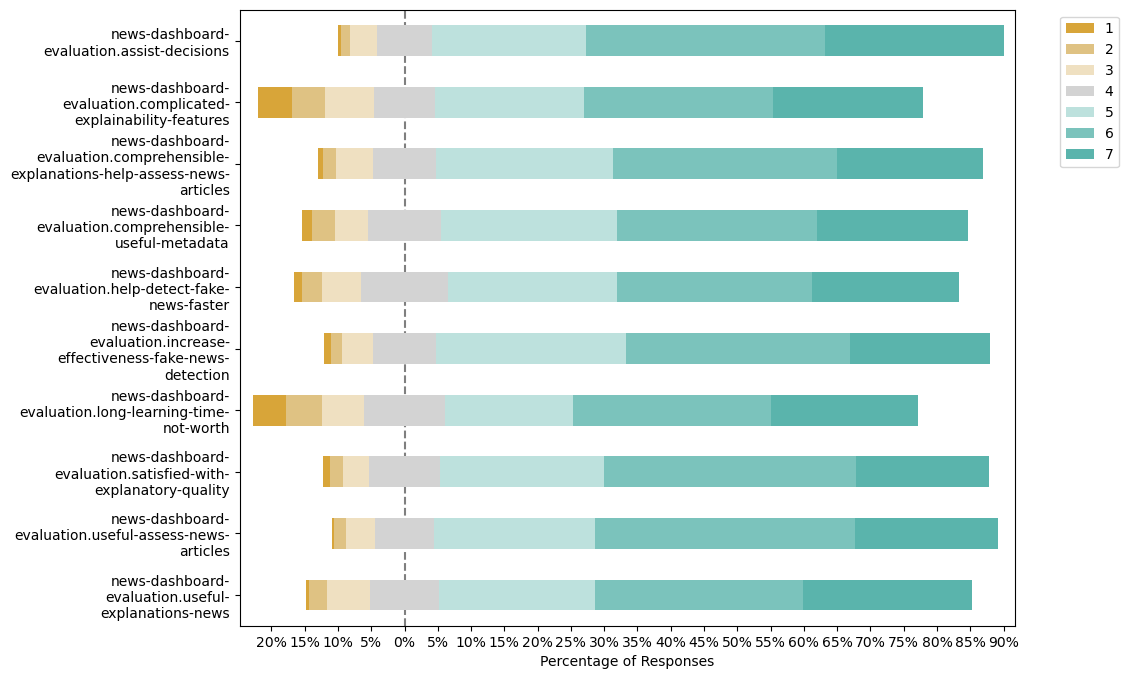

In [37]:
plt.figure(figsize=(100, 100))
pl.plot_likert(likert_data, pl.scales.raw7, colors=pl.colors.likert7, figsize=(10,8), plot_percentage=True, war);

## Use Friedman test to compare accuracy

In [ ]:
friedman = pg.friedman(accuracy_df, dv="accuracy", within="system", subject="index", method='chisq')
highlight(friedman)

In [ ]:
nemenyi = sp.posthoc_nemenyi_friedman(
    accuracy_df,
    melted=True,
    y_col="accuracy",
    block_col="index",
    group_col="system",
)

In [ ]:
values = ['ai_accuracy', 'human_accuracy', 'human_ai_accuracy']
pairs = list(combinations(values, 2))

posthoc = pd.DataFrame(columns=["A", "B", "p-corr", "cohen"])

# create a dataframe for the posthoc results
for pair in pairs:
    posthoc = posthoc.append(
        {
            "A": pair[0],
            "B": pair[1],
            "p-corr": nemenyi.loc[pair[0], pair[1]],
            "cohen": cohen_d(accuracy_df[accuracy_df["system"] == pair[0]]["accuracy"], 
                             accuracy_df[accuracy_df["system"] == pair[1]]["accuracy"]),
        },
        ignore_index=True,
    )

In [ ]:
format_posthoc(posthoc, 
  caption='Pairwise comparisons of the accuracy using Nemenyi post hoc tests',
  label='accuracy_pairwise',
  between_col_mapping={
    'ai_accuracy': 'AI',
    'human_accuracy': 'Human',
    'human_ai_accuracy': 'Human-AI'
  })

## Export news items to latex

In [ ]:
result_str = ""

for index, newsitem in newsitems.iterrows():

    content_latex = newsitem["highlighted_content"].replace("<mark>", "\\ul{").replace("</mark>", "}")
    content_latex = content_latex.replace("<span style='background-color:#00FEFE'>", "\\textbf{\\textit{").replace("</span>", "}}")


    # id
    result_str += ("\\item[] \\textbf{ID}: " + str(newsitem["id"]) + " \\\\\n")
    result_str += ("\\textbf{Label}: " + str("Fake" if newsitem["is_fake_news"] else "True") + " \\\\\n")
    result_str += ("\\textbf{Title}: " + newsitem["title"] + " \\\\\n")
    if not pd.isnull(newsitem["subtitle"]):
        result_str += ("\\textbf{Subtitle}: " + newsitem["subtitle"] + " \\\\\n")
    # category
    result_str += ("\\textbf{Category}: " + newsitem["category"] + " \\\\\n")
    result_str += ("\\textbf{Source}: " + newsitem["source"] + " \\\\\n")
    result_str += ("\\textbf{Publishing date}: " + newsitem["publishing_date"] + " \\\\\n")
    result_str += ("\\textbf{Truthfulness}: " + str(newsitem["truthfulness"]) + "% \\\\\n")
    result_str += ("\\textbf{Readability}: " + str(newsitem["readability"]) + " \\\\\n")
    result_str += ("\\textbf{Content}: " + content_latex + " \\\\\n")
    result_str += ("\\textbf{Free-text explanation}: " + newsitem["natural_language_explanation"] + " \\\\\n")

# escape latex special characters
result_str = result_str.replace("_", "\\_")
result_str = result_str.replace("&", "\\&")
result_str = result_str.replace("%", "\\%")
result_str = result_str.replace("$", "\\$")

result_str = result_str.replace("’", "'")
result_str = result_str.replace("“", "``")
result_str = result_str.replace("”", "''")
result_str = result_str.replace("—", "-")
result_str = result_str.replace(" ", " ")

print(result_str)

## Scheirer-Ray-Hare-Test

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np

# from https://github.com/jpinzonc/Scheirer-Ray-Hare-Test
def srh(data: pd.DataFrame, dv: str, between1: str, between2: str):
    data = data.copy()
    data["rank"] = data[dv].sort_values().rank(numeric_only=True)

    rows = data.groupby([between1], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'row'})
    rows.columns = ['_'.join(col) for col in rows.columns]
    rows.columns = rows.columns.str.replace(r'_$',"", regex=True)
    rows['row_mean_rows'] = rows.row_mean.mean()
    rows['sqdev'] = (rows.row_mean - rows.row_mean_rows)**2

    cols = data.groupby([between2], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'col'})
    cols.columns = ['_'.join(col) for col in cols.columns]
    cols.columns = cols.columns.str.replace(r'_$',"", regex=True)
    cols['col_mean_cols'] = cols.col_mean.mean()
    cols['sqdev'] = (cols.col_mean-cols.col_mean_cols)**2

    data_sum         = data.groupby([between1, between2], as_index = False).agg({'rank':['count', 'mean', 'var']})
    data_sum.columns = ['_'.join(col) for col in data_sum.columns]
    data_sum.columns = data_sum.columns.str.replace(r'_$',"", regex=True)

    nobs_row   = rows.row_count.mean()
    nobs_total = rows.row_count.sum()
    nobs_col   = cols.col_count.mean()

    columns_ss = cols.sqdev.sum()*nobs_col
    rows_ss    = rows.sqdev.sum()*nobs_row
    within_ss  = data_sum.rank_var.sum()*(data_sum.rank_count.min()-1)
    ms         = data['rank'].var()
    total_ss   = ms * (nobs_total-1)
    inter_ss   = total_ss - within_ss - rows_ss - columns_ss

    h_rows = rows_ss/ms
    h_cols = columns_ss/ms
    h_int  = inter_ss/ms

    df_rows   = len(rows)-1
    df_cols   = len(cols)-1
    df_int    = df_rows*df_cols
    df_total  = len(data)-1
    df_within = df_total - df_int - df_cols - df_rows

    p_rows  = 1-stats.chi2.cdf(h_rows, df_rows)
    p_cols  = 1-stats.chi2.cdf(h_cols, df_cols)
    p_inter = 1-stats.chi2.cdf(h_int, df_int)

    # put the results in a dataframe
    results = pd.DataFrame({'Source':[between1, between2, f'{between1}:{between2}', 'Within', 'Total'],
                            'SS':[rows_ss, columns_ss, inter_ss, within_ss, total_ss],
                            'df':[df_rows, df_cols, df_int, df_within, df_total],
                            'MS':[np.nan, np.nan, np.nan, np.nan, total_ss/df_total],
                            'H':[h_rows, h_cols, h_int, np.nan, np.nan],
                            'p':[p_rows, p_cols, p_inter, np.nan, np.nan]})
    
    return results